In [1]:
import datashader as ds
import datashader.transfer_functions as tf
import datashader.glyphs
from datashader import reductions
from datashader.core import bypixel
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
import copy


from pyproj import Proj, transform
import numpy as np
import pandas as pd
import urllib
import json
import datetime
#import colorlover as cl

import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools

# from shapely.geometry import Point, Polygon, shape
# In order to get shapley, you'll need to run [pip install shapely.geometry] from your terminal

from functools import partial

from IPython.display import GeoJSON

py.init_notebook_mode()

import warnings  
warnings.filterwarnings('ignore')

For module 2 we'll be looking at techniques for dealing with big data. In particular binning strategies and the datashader library (which possibly proves we'll never need to bin large data for visualization ever again.)

To demonstrate these concepts we'll be looking at the PLUTO dataset put out by New York City's department of city planning. PLUTO contains data about every tax lot in New York City.

PLUTO data can be downloaded from here. Unzip them to the same directory as this notebook, and you should be able to read them in using this (or very similar) code. Also take note of the data dictionary, it'll come in handy for this assignment.

In [2]:
ny = pd.read_csv('pluto_20v8.csv')
print(ny.shape)

# Getting rid of some outliers
ny = ny[(ny['yearbuilt'] > 1850) & (ny['yearbuilt'] < 2020) & (ny['numfloors'] != 0)]
ny.columns

(858613, 90)


Index(['borough', 'block', 'lot', 'cd', 'ct2010', 'cb2010', 'schooldist',
       'council', 'zipcode', 'firecomp', 'policeprct', 'healthcenterdistrict',
       'healtharea', 'sanitboro', 'sanitdistrict', 'sanitsub', 'address',
       'zonedist1', 'zonedist2', 'zonedist3', 'zonedist4', 'overlay1',
       'overlay2', 'spdist1', 'spdist2', 'spdist3', 'ltdheight', 'splitzone',
       'bldgclass', 'landuse', 'easements', 'ownertype', 'ownername',
       'lotarea', 'bldgarea', 'comarea', 'resarea', 'officearea', 'retailarea',
       'garagearea', 'strgearea', 'factryarea', 'otherarea', 'areasource',
       'numbldgs', 'numfloors', 'unitsres', 'unitstotal', 'lotfront',
       'lotdepth', 'bldgfront', 'bldgdepth', 'ext', 'proxcode', 'irrlotcode',
       'lottype', 'bsmtcode', 'assessland', 'assesstot', 'exempttot',
       'yearbuilt', 'yearalter1', 'yearalter2', 'histdist', 'landmark',
       'builtfar', 'residfar', 'commfar', 'facilfar', 'borocode', 'bbl',
       'condono', 'tract2010', 'xcoo

I'll also do some prep for the geographic component of this data, which we'll be relying on for datashader.

You're not required to know how I'm retrieving the lattitude and longitude here, but for those interested: this dataset uses a flat x-y projection (assuming for a small enough area that the world is flat for easier calculations), and this needs to be projected back to traditional lattitude and longitude.

In [3]:
# wgs84 = Proj("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs")
# nyli = Proj("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs")
# ny['xcoord'] = 0.3048*ny['xcoord']
# ny['ycoord'] = 0.3048*ny['ycoord']
# ny['lon'], ny['lat'] = transform(nyli, wgs84, ny['xcoord'].values, ny['ycoord'].values)

# ny = ny[(ny['lon'] < -60) & (ny['lon'] > -100) & (ny['lat'] < 60) & (ny['lat'] > 20)]

#Defining some helper functions for DataShader
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))


## Part 1: Binning and Aggregation
Binning is a common strategy for visualizing large datasets. Binning is inherent to a few types of visualizations, such as histograms and 2D histograms (also check out their close relatives: 2D density plots and the more general form: heatmaps.

While these visualization types explicitly include binning, any type of visualization used with aggregated data can be looked at in the same way. For example, lets say we wanted to look at building construction over time. This would be best viewed as a line graph, but we can still think of our results as being binned by year:

In [4]:
trace = go.Scatter(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny.groupby('yearbuilt').count()['bbl'].index,
    y = ny.groupby('yearbuilt').count()['bbl']
)

layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number of Lots Built')
)

fig = go.FigureWidget(data = [trace], layout = layout)

fig

FigureWidget({
    'data': [{'type': 'scatter',
              'uid': 'b56c7468-42d4-4dca-987e-d692aa7160c3',
 …

Something looks off... You're going to have to deal with this imperfect data to answer this first question.

But first: some notes on pandas. Pandas dataframes are a different beast than R dataframes, here are some tips to help you get up to speed:

## Question
After a few building collapses, the City of New York is going to begin investigating older buildings for safety. The city is particularly worried about buildings that were unusually tall when they were built, since best-practices for safety hadn’t yet been determined. Create a graph that shows how many buildings of a certain number of floors were built in each year (note: you may want to use a log scale for the number of buildings). Find a strategy to bin buildings (It should be clear 20-29-story buildings, 30-39-story buildings, and 40-49-story buildings were first built in large numbers, but does it make sense to continue in this way as you get taller?)

In [5]:

df = ny[["yearbuilt","numbldgs" ,"numfloors"]]

df = df[(df['numfloors'] != 0) & (df['numbldgs'] != 0)]

# change data type float to int
df['numfloors'] = df['numfloors'].astype(int)
df['yearbuilt'] = df['yearbuilt'].astype(int)


# round the values of column
df['numfloors'] = round(df['numfloors'])
df['yearbuilt'] = round(df['yearbuilt'])


# show unique values of floor count
print(sorted(df['numfloors'].unique()))
#print(sorted(df['numbldgs'].unique()))

# show first 10 rows of data
df.head(n = 5)



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 76, 77, 78, 82, 88, 90, 102, 104]


yearbuilt  numbldgs  numfloors
0       1899       1.0          3
1       1965       1.0          3
2       1920       1.0          2
4       1931       1.0          2
5       1928       1.0          5

In [ ]:
import plotly.express as px
fig = px.scatter(df, x='yearbuilt', y='numfloors',
                 labels={
                     "yearbuilt": "Year Built",
                     "numfloors": "Number of floors"
                 },
                title="Distribution of Number of floors by Year")
fig.show()

The age and number of floors in a building mostly consider evaluating the building is safe or not. The above graph shows 2 buildings have more than 100 floors. Apply bins on numfloors.  

In [ ]:
pd.set_option('display.max_columns', 10)


bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 104]
labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '100-105']

df['bins'] = pd.cut(df['numfloors'],bins = bins,labels = labels)
# print(df['bins'])

print(df.head(n = 5))

# group by data using yearbuilt and bins
df2 = df.groupby(['yearbuilt', 'bins']).count()['numbldgs'].reset_index()

#df2['numbldgs'] = np.log(df2['numbldgs'])

# log transformation on numbldgs
df2['numbldgs'] = np.where(df2['numbldgs']>0, np.log(df2['numbldgs']), 0)

#df3 = df2[df2['yearbuilt'] == 1930]

print(df2.head(n = 5))

In [ ]:
fig2 = px.bar(df2, x="yearbuilt", y="numbldgs", color="bins", 
             labels={
                     "yearbuilt": "Year Built",
                     "numbldgs": "Number of Buildings(using Log)",
                     "bins": "Number of floors"
                 },
             title="Distribution of number of buildings and floors by Year")
fig2.show()

The graphs shows most building have floor between 1-10 and 11-20. The tall builngs which have more than fifty floors are very less. We see in 1930 one tall building made then other are made after 2000. 

## Part 2: Datashader
Datashader is a library from Anaconda that does away with the need for binning data. It takes in all of your datapoints, and based on the canvas and range returns a pixel-by-pixel calculations to come up with the best representation of the data. In short, this completely eliminates the need for binning your data.

As an example, lets continue with our question above and look at a 2D histogram of YearBuilt vs NumFloors:

In [6]:
yearbins = 200
floorbins = 200

yearBuiltCut = pd.cut(ny['yearbuilt'], np.linspace(ny['yearbuilt'].min(), ny['yearbuilt'].max(), yearbins))
numFloorsCut = pd.cut(ny['numfloors'], np.logspace(1, np.log(ny['numfloors'].max()), floorbins))

xlabels = np.floor(np.linspace(ny['yearbuilt'].min(), ny['yearbuilt'].max(), yearbins))
ylabels = np.floor(np.logspace(1, np.log(ny['numfloors'].max()), floorbins))

fig = go.FigureWidget(
    data = [
        go.Heatmap(z = ny.groupby([numFloorsCut, yearBuiltCut])['bbl'].count().unstack().fillna(0).values,
              colorscale = 'Greens', x = xlabels, y = ylabels)
    ]
)

fig

FigureWidget({
    'data': [{'colorscale': [[0.0, 'rgb(247,252,245)'], [0.125,
                             'r…

This shows us the distribution, but it's subject to some biases discussed in the Anaconda notebook Plotting Perils.

Here is what the same plot would look like in datashader:

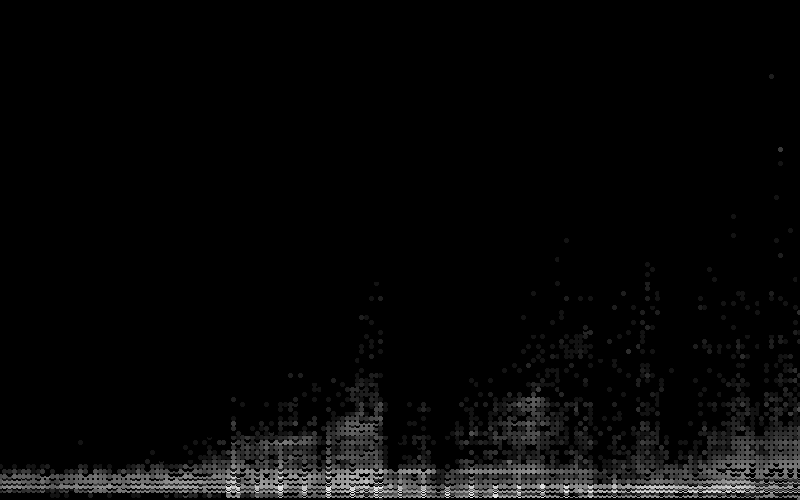

In [7]:
cvs = ds.Canvas(800, 500, x_range = (ny['yearbuilt'].min(), ny['yearbuilt'].max()), 
                                y_range = (ny['numfloors'].min(), ny['numfloors'].max()))
agg = cvs.points(ny, 'yearbuilt', 'numfloors')
view = tf.shade(agg, cmap = cm(Greys9), how='log')
export(tf.spread(view, px=2), 'yearvsnumfloors')

That's technically just a scatterplot, but the points are smartly placed and colored to mimic what one gets in a heatmap. Based on the pixel size, it will either display individual points, or will color the points of denser regions.

Datashader really shines when looking at geographic information. Here are the latitudes and longitudes of our dataset plotted out, giving us a map of the city colored by density of structures:

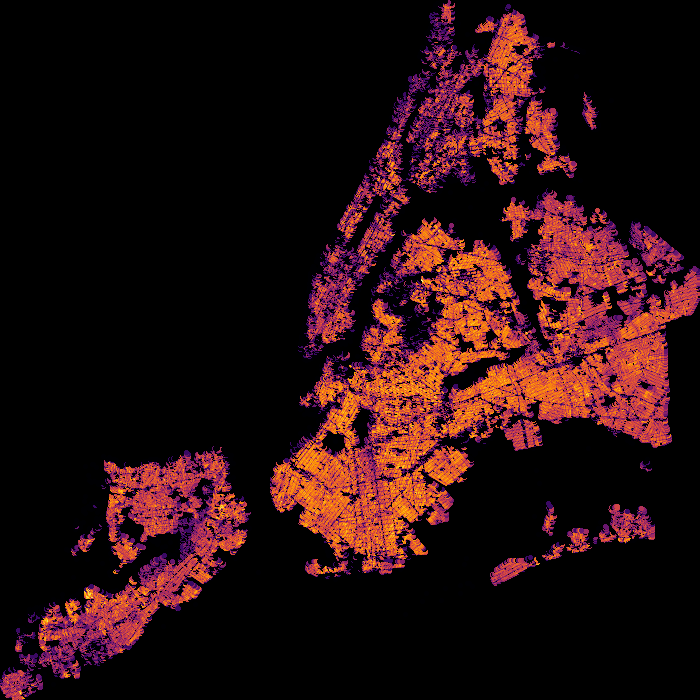

In [8]:
NewYorkCity   = (( 913164.0,  1067279.0), (120966.0, 272275.0))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'xcoord', 'ycoord')
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'firery')

Interestingly, since we're looking at structures, the large buildings of Manhattan show up as less dense on the map. The densest areas measured by number of lots would be single or multi family townhomes.

Unfortunately, Datashader doesn't have the best documentation. Browse through the examples from their github repo. I would focus on the visualization pipeline and the US Census Example for the question below. Feel free to use my samples as templates as well when you work on this problem.

## Question
You work for a real estate developer and are researching underbuilt areas of the city. After looking in the Pluto data dictionary, you've discovered that all tax assessments consist of two parts: The assessment of the land and assessment of the structure. You reason that there should be a correlation between these two values: more valuable land will have more valuable structures on them (more valuable in this case refers not just to a mansion vs a bungalow, but an apartment tower vs a single family home). Deviations from the norm could represent underbuilt or overbuilt areas of the city. You also recently read a really cool blog post about bivariate choropleth maps, and think the technique could be used for this problem.

Datashader is really cool, but it's not that great at labeling your visualization. Don't worry about providing a legend, but provide a quick explanation as to which areas of the city are overbuilt, which areas are underbuilt, and which areas are built in a way that's properly correlated with their land value.

In [9]:
land_df = pd.DataFrame(ny[['assessland', 'assesstot', 'latitude', 'longitude']])


# calculate assessment structure
land_df['asses_struct'] = land_df['assesstot'] - land_df['assessland']


# view data
land_df.head(n = 5)


assessland  assesstot   latitude  longitude  asses_struct
0     24900.0   171420.0  40.809373 -73.953971      146520.0
1     15960.0    72660.0  40.604796 -74.000792       56700.0
2     12900.0    74700.0  40.603001 -74.006399       61800.0
4      5460.0    60060.0  40.618098 -73.957348       54600.0
5    229950.0  1066500.0  40.770826 -73.951806      836550.0

In [10]:
# calculate land assessment value
land_df['asses_land_val'] = pd.qcut(land_df['assessland'],
                   q = 3, labels = ['low','med','high'])

# calculate assessment structure value
land_df['asses_struct_val'] = pd.qcut(land_df['asses_struct'],
                   q = 3, labels = ['low','med','high'])



# concate 2 columns
land_df['map_color'] = land_df.asses_land_val.str.cat(land_df.asses_struct_val, sep = "-")
land_df['map_color'] = pd.Categorical(land_df['map_color'])

# view data
land_df.head()

assessland  assesstot   latitude  longitude  asses_struct asses_land_val  \
0     24900.0   171420.0  40.809373 -73.953971      146520.0           high   
1     15960.0    72660.0  40.604796 -74.000792       56700.0            med   
2     12900.0    74700.0  40.603001 -74.006399       61800.0            med   
4      5460.0    60060.0  40.618098 -73.957348       54600.0            low   
5    229950.0  1066500.0  40.770826 -73.951806      836550.0           high   

  asses_struct_val  map_color  
0             high  high-high  
1             high   med-high  
2             high   med-high  
4              med    low-med  
5             high  high-high

[Link source to bivariate-choropleth-map](https://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/)

Above link suggests sequential bivariate color schemes, assign colors to the categories based on values.

In [11]:
colors = {
    'low-low': '#e8e8e8',
    'low-med': '#b5c0da',
    'low-high': '#c683b5',
    'med-low': '#b8d6be',
    'med-med': '#90b2b3',
    'med-high': '#567994',
    'high-low': '#73ae80',
    'high-med': '#5a9178',
    'high-high': '#2a5a5b'
}



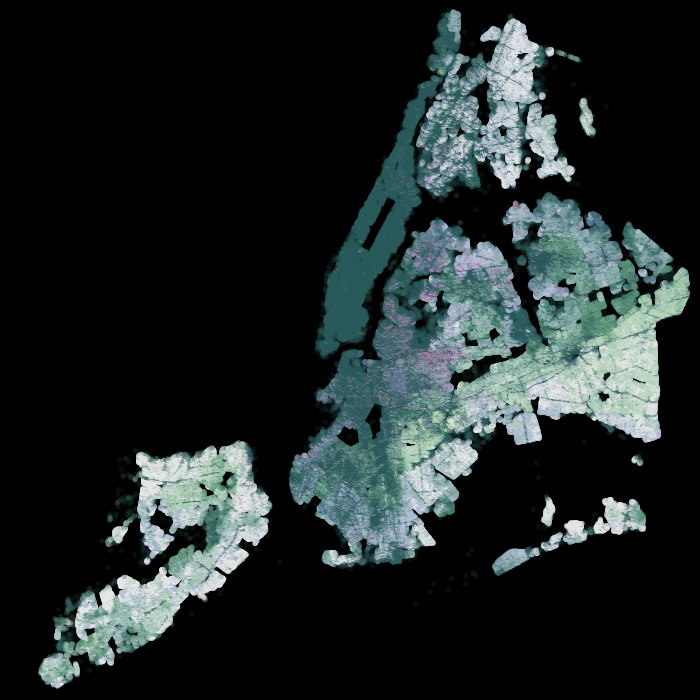

In [12]:

NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(land_df, 'longitude', 'latitude', ds.count_cat('map_color')) 
view = tf.shade(agg, color_key = colors, how='log')
export(tf.spread(view, px=2), 'Assesment_Land_Buildings')

In the map, 

* Area under dark green color have high value land and high value building structure. 
* Area in purple color high structure value and low land value. 
* Area in light green color high land value and low buildings. 
* Area in green-ish white color have low value land and low value buildings. 